---


### `Hyperparameter Tuning for XGBoost`

---

In the last notebook, we did Feature Engineering, and created some features like 

- ***Time Based Features***
- ***Unique number of Manufacturers, Category and SubCategory in a Store***
- ***Lag Feature - Number of units sold 52 weeks before***
- ***Price Difference from the last week***
- ***Average Number of units sold in the last two months***

---

Now, In this Notebook we will use a gradient boosting based model - XGBoost (Extreme Gradient Boosting). Gradient boosting models tend to overfit quickly and hence careful tuning of hyperparameters is required in order to avoid this. Here we will tune the following parameters:

- **`N_ESTIMATORS`** :  Number of trees to fit
- **`MAX_DEPTH`** :  Maximum tree depth for base learners
- **`GAMMA`** : Minimum loss reduction required to make a further partition on a leaf node of the tree.
- **`MIN_CHILD_WEIGHT`** : Minimum sum of instance weight needed in a child.
- **`SUBSAMPLE`** : Subsample ratio of the training instance.

---

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta

from sklearn.metrics import mean_squared_log_error as msle

In [2]:
# read the final data set with the newly created features
data = pd.read_csv('final_data.csv')

In [3]:
# top rows of the data
data.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MANUFACTURER_1,MANUFACTURER_2,MANUFACTURER_3,...,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,2_MONTH_BEFORE,1_WEEK_BEFORE,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0


In [4]:
# convert the WEEK_END_DATE to datetime format
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [5]:
# let's look at all the features we have in the first row.
data.loc[0]

WEEK_END_DATE               2009-01-14 00:00:00
STORE_NUM                                   367
UPC                                  1111009477
BASE_PRICE                                 1.57
FEATURE                                       0
DISPLAY                                       0
UNITS                                        13
MANUFACTURER_1                                1
MANUFACTURER_2                                0
MANUFACTURER_3                                0
MANUFACTURER_4                                0
MANUFACTURER_5                                0
MANUFACTURER_6                                0
MANUFACTURER_7                                0
MANUFACTURER_8                                0
MANUFACTURER_9                                0
CATEGORY_1                                    1
CATEGORY_2                                    0
CATEGORY_3                                    0
CATEGORY_4                                    0
SUB_CATEGORY_1                          

In [6]:
# we will drop the 2 date columns,  2_MONTH_BEFORE and 1_WEEK_BEFORE as they are not required now.
data = data.drop(columns=['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [7]:
# check for the null values
data.isna().sum().sum()

0

---
### `Validation Sets`

- We will use the same `validation_df` function to create the validation sets. 
- It will take the parameters, a list of unique WEEK_END_DATES, dataset and no of months in training period and no of training validation sets required.
- We will use the training period of 2 months and 14 validation sets as discussed in the Validation Strategy Notebook.
---

In [8]:
# create an array of unique week dates
week = data.WEEK_END_DATE.unique()

In [9]:

def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [10]:
# we will use the same combination of 2 month training data with 14 validation sets
validation_df(data, week, no_of_months=2, no_of_validation= 14)

,no_days_train,set_no,test_shape,test_week,train_end,train_shape,train_start,validate_week,validation_shape
0,56 days,set1,1642,2011-09-28,2011-08-31,13089,2011-07-13,2011-09-14,1640
1,56 days,set2,1638,2011-09-21,2011-08-24,13102,2011-07-06,2011-09-07,1632
2,56 days,set3,1640,2011-09-14,2011-08-17,13101,2011-06-29,2011-08-31,1629
3,56 days,set4,1632,2011-09-07,2011-08-10,13101,2011-06-22,2011-08-24,1640
4,56 days,set5,1629,2011-08-31,2011-08-03,13109,2011-06-15,2011-08-17,1638
5,56 days,set6,1640,2011-08-24,2011-07-27,13108,2011-06-08,2011-08-10,1631
6,56 days,set7,1638,2011-08-17,2011-07-20,13108,2011-06-01,2011-08-03,1640
7,56 days,set8,1631,2011-08-10,2011-07-13,13112,2011-05-25,2011-07-27,1637
8,56 days,set9,1640,2011-08-03,2011-07-06,13104,2011-05-18,2011-07-20,1635
9,56 days,set10,1637,2011-07-27,2011-06-29,13101,2011-05-11,2011-07-13,1639


---

- We will create a list of tuples `evaluation_set` that will contain train and validation data extracted using the validation dataframe.
- We will use the columns `train_start`, `train_end` and `validate_week` and filter out the data which lies in that training period and validation period.
- We will define a function `get_evaluation_sets` to get the required list of tuples. The output list will look something like the following list.



***`evaluation_set = [  (train_set_1, validation_set_1),
                     (),
                     (),
                     .
                     .
                     .
                     ( train_set_n, validation_set_n)  ]`***

---

In [11]:
# train validation set
def get_evaluation_sets(df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['validate_week'])
        # get the train data
        train_data = data[(data.WEEK_END_DATE >= df.loc[row]['train_start']) & (data.WEEK_END_DATE <= df.loc[row]['train_end'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        evaluation_set.append((train_data, validation_data))
    return evaluation_set

In [12]:
# store the train and validation sets in a list
evaluation_set = get_evaluation_sets(validation_df(data, week, no_of_months=2, no_of_validation=14))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00
2011-07-13 00:00:00
2011-07-06 00:00:00
2011-06-29 00:00:00
2011-06-22 00:00:00
2011-06-15 00:00:00


---

Now, We will define one function to calculate the RMSLE `get_msle` and custom evaluation metric function `custom_eval` for the XGBoost Regressor. This custom evaluation metric is very simple and just calculates the same RMSLE value as we did for other models. We have done this because XGBoost does not have it internally defined.

---

In [13]:

# function to calculate the RMSLE
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))


# custom evaluation metric function for the XGBoost
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = preds.clip(min=0)
    
    return [('rmsle', get_msle(labels, preds))]


---

### `N_ESTIMATORS`

- We cannot use the function XGBoost.cv to find out the best set of parameters as it randomly splits the data. Here we have a time series data so we will use the same 14 validation sets and take average.
- We will track both the train RMSLE and validation RMSLE for different n estimators and check the scores
- First of all, we will tune `N_ESTIMATORS` and we will find mean RMSLE over 14 validation sets that we have defined.
- We will check for the n_estimators value for the values 20, 40, 60, ..... 400.

---

In [14]:
def get_n_estimators(evaluation_set, min_r, max_r):
    
    results = []
    
    for n_est in (range(min_r, max_r, 20)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for train, valid in (evaluation_set):
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            
            # define the XGBRegressor Model 
            model = xgb.XGBRegressor(n_estimators = n_est,
                                     learning_rate = 0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            # fit the model
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)
            
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
            
        # calculate the mean rmsle on train and valid
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With N_ESTIMATORS:\t'+ str(n_est) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train) + "\tMEAN RMSLE VALID: "+str(mean_score_valid))
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
        

    return pd.DataFrame.from_dict(results) 

In [15]:
n_estimators_result = get_n_estimators(evaluation_set,min_r = 20, max_r = 901)

With N_ESTIMATORS:	20	MEAN RMSLE TRAIN:	1.3655357857142858	MEAN RMSLE VALID: 1.3646570714285713
With N_ESTIMATORS:	40	MEAN RMSLE TRAIN:	0.9561604285714286	MEAN RMSLE VALID: 0.9568562142857143
With N_ESTIMATORS:	60	MEAN RMSLE TRAIN:	0.7452255714285715	MEAN RMSLE VALID: 0.7508122857142858
With N_ESTIMATORS:	80	MEAN RMSLE TRAIN:	0.6257344285714286	MEAN RMSLE VALID: 0.6371919285714285
With N_ESTIMATORS:	100	MEAN RMSLE TRAIN:	0.5559502142857143	MEAN RMSLE VALID: 0.5735750000000001
With N_ESTIMATORS:	120	MEAN RMSLE TRAIN:	0.5159422142857143	MEAN RMSLE VALID: 0.5388188571428572
With N_ESTIMATORS:	140	MEAN RMSLE TRAIN:	0.49303371428571424	MEAN RMSLE VALID: 0.5196828571428571
With N_ESTIMATORS:	160	MEAN RMSLE TRAIN:	0.4797654285714286	MEAN RMSLE VALID: 0.5094190714285716
With N_ESTIMATORS:	180	MEAN RMSLE TRAIN:	0.47228735714285713	MEAN RMSLE VALID: 0.5037192857142857
With N_ESTIMATORS:	200	MEAN RMSLE TRAIN:	0.4679698571428572	MEAN RMSLE VALID: 0.5013480714285715
With N_ESTIMATORS:	220	MEAN RMSL

---

- We can see that RMSLE gets stable at 0.479 with n_estimators more than 700.
- And on the validation set RMSLE starts increasing again with n_estimators value 820 while the training RMSLE is continuously improving
- RMSLE at validation is lowest with n_estimators value 720, so we will fix this value and tune the model for the best value of max_depth.

---

### `MAX_DEPTH`

- Next very important hyperparameter to be tuned is Max Depth. This is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
- Now, we will check the performance of the model for various max_depth values 2, 3, ....14.
- If the performance keeps improving till max_depth 14, we will increase the values and try again.

---

In [17]:
def get_max_depth(evaluation_set):
    
    results = []
    
    for depth in (range(2, 15, 1)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for train, valid in (evaluation_set):
                        
            # seperate the independent and target variable from the train and validation set    
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']
            
            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [ (train_data_x, train_data_y),(valid_data_x, valid_data_y)]

            # fit the model keeping the n_estimator value fixed 720
            model = xgb.XGBRegressor(n_estimators = 720,
                                     max_depth=depth,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
        # calculate the mean rmsle on train and valid   
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
    
        print('With DEPTH:\t'+ str(depth) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+ '\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['depth']= depth
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame.from_dict(results)

In [18]:
max_depth_results = get_max_depth(evaluation_set)

With DEPTH:	2	MEAN RMSLE TRAIN:	0.4727829285714286	MEAN RMSLE VALID: 0.510592
With DEPTH:	3	MEAN RMSLE TRAIN:	0.42870921428571424	MEAN RMSLE VALID: 0.47793221428571436
With DEPTH:	4	MEAN RMSLE TRAIN:	0.4008241428571428	MEAN RMSLE VALID: 0.46364599999999995
With DEPTH:	5	MEAN RMSLE TRAIN:	0.3796030714285714	MEAN RMSLE VALID: 0.46506028571428565
With DEPTH:	6	MEAN RMSLE TRAIN:	0.3601991428571428	MEAN RMSLE VALID: 0.4605922142857143
With DEPTH:	7	MEAN RMSLE TRAIN:	0.33986921428571426	MEAN RMSLE VALID: 0.4612017857142856
With DEPTH:	8	MEAN RMSLE TRAIN:	0.3187993571428572	MEAN RMSLE VALID: 0.46384485714285717
With DEPTH:	9	MEAN RMSLE TRAIN:	0.2950674285714286	MEAN RMSLE VALID: 0.46604014285714285
With DEPTH:	10	MEAN RMSLE TRAIN:	0.2669810714285714	MEAN RMSLE VALID: 0.4656375714285714
With DEPTH:	11	MEAN RMSLE TRAIN:	0.23624592857142854	MEAN RMSLE VALID: 0.46647528571428565
With DEPTH:	12	MEAN RMSLE TRAIN:	0.20559471428571427	MEAN RMSLE VALID: 0.4710164999999999
With DEPTH:	13	MEAN RMSLE TRA

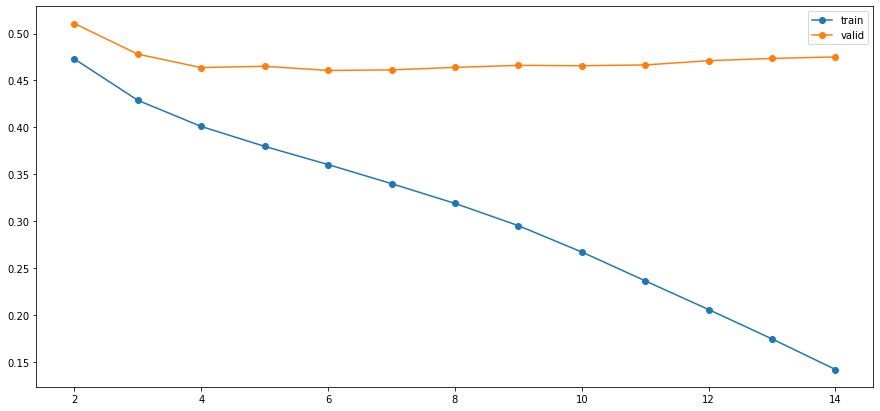

In [19]:
plt.figure(figsize=(15,7))
plt.plot(max_depth_results['depth'], max_depth_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(max_depth_results['depth'], max_depth_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

---

- We can see that the model starts overfitting with max_depth more than 4 as it is improving only on train data.
- So, we will fix the value of max_depth to 4 and find out the best value of min_child_weight

---

### `MIN_CHILD_WEIGHT`

- `min_child_weight` is another parameter to control overfitting. The larger min_child_weight is, the more bias the algorithm has.
- We will check the performance of the model for the values 1 to 5.
- The value of n_estimators will be 720 and max_depth will be 4.

---

In [20]:
def get_min_child_weight(evaluation_set):
    
    results = []
    
    for mcw in (range(1, 6, 1)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for train, valid in (evaluation_set):
                        
            # separate the independent and target variables from the train and valid data.    
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']
            
            
            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [(train_data_x, train_data_y),(valid_data_x, valid_data_y)]

            model = xgb.XGBRegressor(n_estimators = 720,
                                     max_depth=4,
                                     min_child_weight= mcw,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
            
        # calculate the mean rmsle on train and valid     
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With Min Child Weight:\t'+ str(mcw) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+ '\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['mcw'] = mcw
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame.from_dict(results)

In [21]:
mcw_results = get_min_child_weight(evaluation_set)

With Min Child Weight:	1	MEAN RMSLE TRAIN:	0.4008241428571428	MEAN RMSLE VALID: 0.46364599999999995
With Min Child Weight:	2	MEAN RMSLE TRAIN:	0.4007882142857143	MEAN RMSLE VALID: 0.4630388571428572
With Min Child Weight:	3	MEAN RMSLE TRAIN:	0.4009015000000001	MEAN RMSLE VALID: 0.46427192857142857
With Min Child Weight:	4	MEAN RMSLE TRAIN:	0.4006355714285714	MEAN RMSLE VALID: 0.46499285714285715
With Min Child Weight:	5	MEAN RMSLE TRAIN:	0.4007522857142857	MEAN RMSLE VALID: 0.46515264285714286


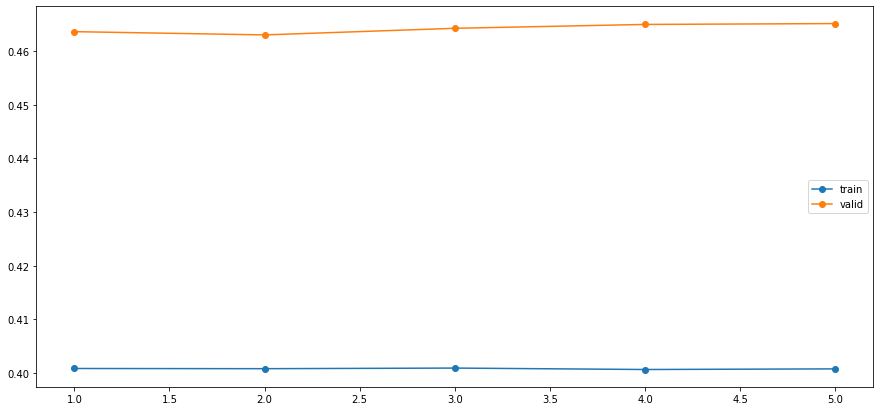

In [22]:
plt.figure(figsize=(15,7))
plt.plot(mcw_results['mcw'], mcw_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(mcw_results['mcw'], mcw_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

---

- The values of `min_child_weight` doesn't make much difference to the model performance. So, we will choose any smaller value to keep the model less complex.   
- So, we will fix `min_child_weight` as 2 and find out the best value of gamma.

---

### `GAMMA`

- A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. The larger gamma is, the more biased the algorithm will be.
- We will check the performance of the model on values 0, 0.01, 0.1, 0.5, 1, 10 and 100.

---

In [23]:
def get_gamma(evaluation_set):
    
    results = []
    
    for g in [0, 0.01, 0.1, 0.5, 1, 10, 100]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in (evaluation_set):
                        
            # separate the target and independent variables from the train and valid    
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            
            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [ (train_data_x, train_data_y), (valid_data_x, valid_data_y)]

            # fit the model 
            model = xgb.XGBRegressor(n_estimators = 720,
                                     max_depth=4,
                                     min_child_weight= 2,
                                     gamma=g,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
            
        # calculate the mean rmsle on train and valid.    
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With Gamma:\t'+ str(g) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+'\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['gamma'] = g
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame.from_dict(results)

In [24]:
gamma_results= get_gamma(evaluation_set)

With Gamma:	0	MEAN RMSLE TRAIN:	0.4007882142857143	MEAN RMSLE VALID: 0.4630388571428572
With Gamma:	0.01	MEAN RMSLE TRAIN:	0.4007882142857143	MEAN RMSLE VALID: 0.4630388571428572
With Gamma:	0.1	MEAN RMSLE TRAIN:	0.4007882142857143	MEAN RMSLE VALID: 0.4630388571428572
With Gamma:	0.5	MEAN RMSLE TRAIN:	0.4007882142857143	MEAN RMSLE VALID: 0.4630389285714286
With Gamma:	1	MEAN RMSLE TRAIN:	0.40080828571428573	MEAN RMSLE VALID: 0.46302392857142866
With Gamma:	10	MEAN RMSLE TRAIN:	0.4007325714285715	MEAN RMSLE VALID: 0.4631236428571429
With Gamma:	100	MEAN RMSLE TRAIN:	0.4009129285714286	MEAN RMSLE VALID: 0.46337200000000006


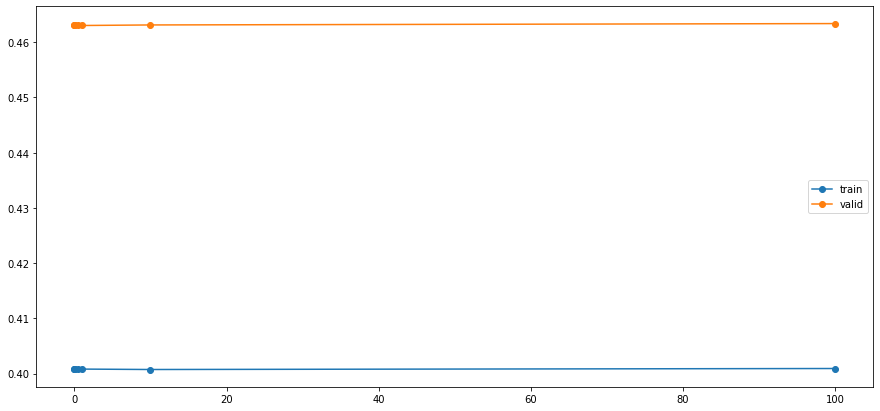

In [25]:
plt.figure(figsize=(15,7))
plt.plot(gamma_results['gamma'], gamma_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(gamma_results['gamma'], gamma_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

---

- The value of gamma is also not making much difference to the model performance.
- We will keep the value of gamma fixed to 0 and find the best value of the subsample.


### `SUB SAMPLE`

- Subsample ratio of the training instances. Setting it to a value less than 1 means that XGBoost would randomly sample a percentage of the training data prior to growing trees and this will prevent overfitting. 
- We will choose different values from 0 to 1 and check the performance.

---

In [26]:
def get_subsample(evaluation_set):
    
    results = []
    
    for ss in [ 0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in (evaluation_set):
            
            # separate the independent and target variable from train and valid
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [ (train_data_x, train_data_y), (valid_data_x, valid_data_y)]

            # fit the model
            model = xgb.XGBRegressor(n_estimators = 720,
                                     subsample=ss,
                                     max_depth=4,
                                     min_child_weight= 2,
                                     gamma=0,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
        # calculate the mean rmsle on train and valid.
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With Subsample:\t'+ str(ss) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+'\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['sub_sample'] = ss
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame.from_dict(results)

In [27]:
subsample_results = get_subsample(evaluation_set)

With Subsample:	0.01	MEAN RMSLE TRAIN:	0.4290293571428571	MEAN RMSLE VALID: 0.4820673571428572
With Subsample:	0.05	MEAN RMSLE TRAIN:	0.41628135714285713	MEAN RMSLE VALID: 0.46945721428571435
With Subsample:	0.075	MEAN RMSLE TRAIN:	0.4152914285714286	MEAN RMSLE VALID: 0.47027478571428577
With Subsample:	0.1	MEAN RMSLE TRAIN:	0.41419700000000004	MEAN RMSLE VALID: 0.4685147857142857
With Subsample:	0.4	MEAN RMSLE TRAIN:	0.40639192857142853	MEAN RMSLE VALID: 0.46711885714285717
With Subsample:	0.6	MEAN RMSLE TRAIN:	0.40301585714285704	MEAN RMSLE VALID: 0.4651850714285714
With Subsample:	0.7	MEAN RMSLE TRAIN:	0.40198971428571423	MEAN RMSLE VALID: 0.4648130714285715
With Subsample:	0.8	MEAN RMSLE TRAIN:	0.4009331428571428	MEAN RMSLE VALID: 0.46436071428571424
With Subsample:	0.9	MEAN RMSLE TRAIN:	0.4001194285714285	MEAN RMSLE VALID: 0.4640319285714286
With Subsample:	0.95	MEAN RMSLE TRAIN:	0.4000869285714286	MEAN RMSLE VALID: 0.46309871428571425
With Subsample:	0.97	MEAN RMSLE TRAIN:	0.4001

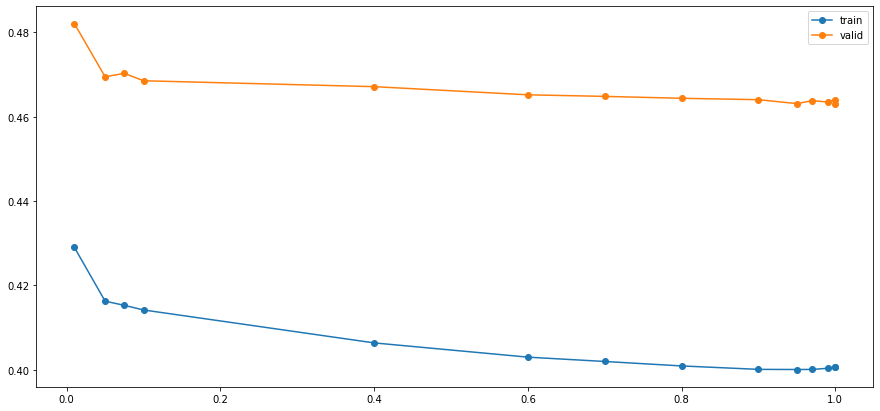

In [28]:
plt.figure(figsize=(15,7))
plt.plot(subsample_results['sub_sample'], subsample_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(subsample_results['sub_sample'], subsample_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

---

- We can see that with increase in subsample ratio the model performance improves on both the train and validation. 




---

---

### `Final Hyperparameters`

So after all the steps for tuning the hyperparameters for XGBoost, this is what we have. 


- **`N_ESTIMATORS`** :  720
- **`MAX_DEPTH`** :  4
- **`LEARNING RATE`** : 0.01
- **`GAMMA`** : 0
- **`MIN_CHILD_WEIGHT`** : 2
- **`SUBSAMPLE`** : 1

Lower the learning rate and simultaneously tune the number of estimators to finally finetune this model.

---